# Speaker Subspace Removal Analysis with WavLM

이 노트북은 WavLM에서 추출한 feature에 대해 speaker subspace를 제거하는 효과를 UMAP으로 시각화합니다.

## 실험 목표
1. WavLM feature 추출
2. Speaker subspace 제거 전/후 비교
3. n_speaker_components를 점점 키우면서 효과 관찰
4. UMAP으로 시각화하여 화자 정보가 얼마나 제거되는지 확인

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import librosa
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from transformers import WavLMModel, Wav2Vec2FeatureExtractor
import umap
import matplotlib.cm as cm
from tqdm.auto import tqdm

# 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

/mnt/fr20tb/kyudan/miniforge3/envs/deepfake/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 1. 데이터 준비 (LibriSpeech 활용)

In [2]:
from libri_dataframe import build_librispeech_dataframe

LIBRISPEECH_ROOT = "./my_raw_audio/LibriSpeech"
LIBRISPEECH_SUBSET = "test-clean"

dataframe = build_librispeech_dataframe(
    librispeech_root=LIBRISPEECH_ROOT,
    subset=LIBRISPEECH_SUBSET,
)

# 처음 1000개만 사용
dataframe_10 = dataframe[:1000]
print(f"Total samples: {len(dataframe_10)}")
print(f"Number of speakers: {dataframe_10['speaker_id'].nunique()}")
dataframe_10.head()

Total samples: 1000
Number of speakers: 16


speaker_id chapter_id utterance_id  \
0       1089     134686         0000   
1       1089     134686         0001   
2       1089     134686         0002   
3       1089     134686         0003   
4       1089     134686         0004   

                                          audio_path  \
0  my_raw_audio/LibriSpeech/test-clean/1089/13468...   
1  my_raw_audio/LibriSpeech/test-clean/1089/13468...   
2  my_raw_audio/LibriSpeech/test-clean/1089/13468...   
3  my_raw_audio/LibriSpeech/test-clean/1089/13468...   
4  my_raw_audio/LibriSpeech/test-clean/1089/13468...   

                                          transcript  
0  HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...  
1         STUFF IT INTO YOU HIS BELLY COUNSELLED HIM  
2  AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...  
3                 HELLO BERTIE ANY GOOD IN YOUR MIND  
4  NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...

## 2. WavLM Feature Extraction

In [3]:
# WavLM-Large 모델 로드
print("Loading WavLM-Large model...")
model_name = "microsoft/wavlm-large"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = WavLMModel.from_pretrained(model_name).to(device)
model.eval()
print("Model loaded successfully!")

Loading WavLM-Large model...
Model loaded successfully!


In [5]:
def extract_wavlm_features(audio_path, model, feature_extractor, device):
    """
    WavLM-Large를 통과한 latent representation을 추출합니다.
    
    Args:
        audio_path: 오디오 파일 경로
        model: WavLM 모델
        feature_extractor: WavLM feature extractor
        device: 'cuda' 또는 'cpu'
    
    Returns:
        평균 풀링된 encoder output (numpy array)
    """
    try:
        # 1. 오디오 로드 (librosa 사용, WavLM은 16kHz 필요)
        audio, sr = librosa.load(str(audio_path), sr=16000, mono=True)
        
        # 2. 오디오를 WavLM 입력 형식으로 변환
        inputs = feature_extractor(
            audio, 
            sampling_rate=16000, 
            return_tensors="pt",
            padding=True
        )
        input_values = inputs.input_values.to(device)
        
        # 3. Forward pass
        with torch.no_grad():
            outputs = model(input_values)
            # outputs.last_hidden_state: (batch, seq_len, hidden_dim=1024 for large)
        
        # 4. 시퀀스 차원에 대해 평균 풀링
        pooled_features = outputs.last_hidden_state.mean(dim=1).squeeze(0).cpu().numpy()
        
        return pooled_features
    
    except Exception as e:
        print(f"Error extracting features from {audio_path}: {e}")
        return None

In [6]:
# Feature 추출 (Original vs Gen 2)
features = []
labels = []  # 0: Real, 1: Fake
speaker_ids = []
filenames = []

target_groups = ["Original (Real)", "Gen 2 (Voice Conversion)"]
label_map = {name: i for i, name in enumerate(target_groups)}

print("Extracting WavLM-Large encoder features...")
for i, row in enumerate(tqdm(dataframe_10.to_dict('records'))):
    base_name = Path(row['audio_path']).stem
    speaker_id = row['speaker_id']
    
    file_paths = {
        "Original (Real)": Path(row['audio_path']).resolve(),
        "Gen 2 (Voice Conversion)": Path(f"generated_results/speaker_libri_transcript_{base_name}.wav")
    }
    
    for group_name, path in file_paths.items():
        if not path.exists(): 
            continue
            
        vec = extract_wavlm_features(path, model, feature_extractor, device)
        
        if vec is not None:
            features.append(vec)
            labels.append(label_map[group_name])
            speaker_ids.append(speaker_id)
            filenames.append(base_name)

X = np.array(features)
y = np.array(labels)
speaker_ids = np.array(speaker_ids)

print(f"\nFeature extraction complete!")
print(f"Data shape: {X.shape}")
print(f"Total samples: {len(X)}, Feature dimension: {X.shape[1]}")
print(f"Number of unique speakers: {len(np.unique(speaker_ids))}")

Extracting WavLM-Large encoder features...


100%|██████████| 1000/1000 [05:31<00:00,  3.02it/s]


Feature extraction complete!
Data shape: (2000, 1024)
Total samples: 2000, Feature dimension: 1024
Number of unique speakers: 16


## 3. Speaker Subspace 제거 함수 구현

In [7]:
def compute_speaker_subspace(X, speaker_ids, n_components):
    """
    Speaker Subspace를 계산하고 제거하는 projection matrix를 반환합니다.
    
    전략:
    1. 각 화자별 평균(centroid) 계산
    2. 화자 평균들에 대해 PCA 수행 -> 주요 화자 방향 추출
    3. Orthogonal Projection Matrix (P_perp = I - UU^T) 계산
    
    Args:
        X: Feature matrix (n_samples, n_features)
        speaker_ids: Speaker ID array (n_samples,)
        n_components: 제거할 주요 화자 차원 수
    
    Returns:
        projection_matrix: Speaker info를 제거하는 투영 행렬
        pca: 학습된 PCA 객체 (분석용)
    """
    # 화자별 평균 계산
    unique_speakers = np.unique(speaker_ids)
    speaker_centroids = []
    
    for spk in unique_speakers:
        mask = (speaker_ids == spk)
        centroid = np.mean(X[mask], axis=0)
        speaker_centroids.append(centroid)
    
    speaker_centroids = np.array(speaker_centroids)
    print(f"Computing PCA on {len(speaker_centroids)} speaker centroids...")
    
    # PCA로 주요 화자 방향 찾기
    pca = PCA(n_components=n_components)
    pca.fit(speaker_centroids)
    
    # Orthogonal Projection Matrix 계산
    # U: (n_features, n_components)
    U = pca.components_.T
    I = np.eye(U.shape[0])
    projection_matrix = I - (U @ U.T)
    
    print(f"Explained variance by top {n_components} components: {sum(pca.explained_variance_ratio_):.4f}")
    
    return projection_matrix, pca

def remove_speaker_info(X, projection_matrix):
    """
    Feature에서 speaker 정보를 제거합니다.
    
    Args:
        X: Feature matrix (n_samples, n_features)
        projection_matrix: Speaker subspace를 제거하는 투영 행렬
    
    Returns:
        X_projected: Speaker 정보가 제거된 feature matrix
    """
    return X @ projection_matrix

## 4. UMAP 시각화 함수

In [8]:
def plot_umap_comparison(X_original, X_projected, y, speaker_ids, n_components, filenames):
    """
    Speaker subspace 제거 전후 UMAP 비교 시각화
    
    Args:
        X_original: 원본 feature (scaled)
        X_projected: Speaker info 제거 후 feature
        y: Label array (0: Real, 1: Fake)
        speaker_ids: Speaker ID array
        n_components: 제거한 speaker dimension 수
        filenames: 파일명 리스트 (화살표 연결용)
    """
    # UMAP 파라미터
    n_neighbors = min(15, len(X_original) - 1)
    min_dist = 0.3
    
    # UMAP 적용
    print(f"Running UMAP on original features...")
    reducer_orig = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=2,
        min_dist=min_dist,
        metric='euclidean',
        random_state=42
    )
    X_umap_orig = reducer_orig.fit_transform(X_original)
    
    print(f"Running UMAP on projected features...")
    reducer_proj = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=2,
        min_dist=min_dist,
        metric='euclidean',
        random_state=42
    )
    X_umap_proj = reducer_proj.fit_transform(X_projected)
    
    # 시각화 준비
    colors_type = ['blue', 'green']  # Real, Fake
    markers = ['o', '^']
    labels_type = ['Real', 'Fake']
    
    # Speaker별 색상 맵
    unique_speakers = sorted(list(set(speaker_ids)))
    cmap = cm.get_cmap('tab20', len(unique_speakers))
    speaker_to_idx = {spk: idx for idx, spk in enumerate(unique_speakers)}
    
    # 4개 서브플롯 (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(20, 18))
    
    # --- Row 1: Original Features ---
    
    # (0, 0): Original - Colored by Type
    ax = axes[0, 0]
    for label_idx, label_name in enumerate(labels_type):
        mask = (y == label_idx)
        ax.scatter(
            X_umap_orig[mask, 0], X_umap_orig[mask, 1],
            c=colors_type[label_idx], label=label_name, marker=markers[label_idx],
            s=100, alpha=0.7, edgecolors='white', linewidths=1.5, zorder=2
        )
    
    # 화살표 (Real -> Fake)
    unique_files = sorted(list(set(filenames)))
    for base_name in unique_files:
        orig_indices = [i for i, (f, l) in enumerate(zip(filenames, y)) if f == base_name and l == 0]
        gen2_indices = [i for i, (f, l) in enumerate(zip(filenames, y)) if f == base_name and l == 1]
        
        if orig_indices and gen2_indices:
            start_pos = X_umap_orig[orig_indices[0]]
            end_pos = X_umap_orig[gen2_indices[0]]
            
            ax.annotate(
                "", xy=end_pos, xytext=start_pos,
                arrowprops=dict(arrowstyle="-|>", color='gray', alpha=0.3, linewidth=1.0, shrinkA=5, shrinkB=5),
                zorder=1
            )
    
    ax.set_title("Before Removal: Colored by Type (Real/Fake)", fontsize=14, fontweight='bold')
    ax.set_xlabel("UMAP Dimension 1", fontsize=11)
    ax.set_ylabel("UMAP Dimension 2", fontsize=11)
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # (0, 1): Original - Colored by Speaker
    ax = axes[0, 1]
    for spk_idx, spk_id in enumerate(unique_speakers):
        for type_idx, marker in enumerate(markers):
            mask = (speaker_ids == spk_id) & (y == type_idx)
            if np.sum(mask) > 0:
                ax.scatter(
                    X_umap_orig[mask, 0], X_umap_orig[mask, 1],
                    c=[cmap(spk_idx)], marker=marker,
                    s=100, alpha=0.7, edgecolors='white', linewidths=1.5,
                    label=f"Speaker {spk_id}" if type_idx == 0 else None,
                    zorder=2
                )
    
    ax.set_title("Before Removal: Colored by Speaker ID", fontsize=14, fontweight='bold')
    ax.set_xlabel("UMAP Dimension 1", fontsize=11)
    ax.set_ylabel("UMAP Dimension 2", fontsize=11)
    ax.legend(fontsize=8, loc='best', ncol=3)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # --- Row 2: After Speaker Subspace Removal ---
    
    # (1, 0): After Removal - Colored by Type
    ax = axes[1, 0]
    for label_idx, label_name in enumerate(labels_type):
        mask = (y == label_idx)
        ax.scatter(
            X_umap_proj[mask, 0], X_umap_proj[mask, 1],
            c=colors_type[label_idx], label=label_name, marker=markers[label_idx],
            s=100, alpha=0.7, edgecolors='white', linewidths=1.5, zorder=2
        )
    
    # 화살표 (Real -> Fake)
    for base_name in unique_files:
        orig_indices = [i for i, (f, l) in enumerate(zip(filenames, y)) if f == base_name and l == 0]
        gen2_indices = [i for i, (f, l) in enumerate(zip(filenames, y)) if f == base_name and l == 1]
        
        if orig_indices and gen2_indices:
            start_pos = X_umap_proj[orig_indices[0]]
            end_pos = X_umap_proj[gen2_indices[0]]
            
            ax.annotate(
                "", xy=end_pos, xytext=start_pos,
                arrowprops=dict(arrowstyle="-|>", color='gray', alpha=0.3, linewidth=1.0, shrinkA=5, shrinkB=5),
                zorder=1
            )
    
    ax.set_title(f"After Removal (n={n_components}): Colored by Type (Real/Fake)", fontsize=14, fontweight='bold')
    ax.set_xlabel("UMAP Dimension 1", fontsize=11)
    ax.set_ylabel("UMAP Dimension 2", fontsize=11)
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # (1, 1): After Removal - Colored by Speaker
    ax = axes[1, 1]
    for spk_idx, spk_id in enumerate(unique_speakers):
        for type_idx, marker in enumerate(markers):
            mask = (speaker_ids == spk_id) & (y == type_idx)
            if np.sum(mask) > 0:
                ax.scatter(
                    X_umap_proj[mask, 0], X_umap_proj[mask, 1],
                    c=[cmap(spk_idx)], marker=marker,
                    s=100, alpha=0.7, edgecolors='white', linewidths=1.5,
                    label=f"Speaker {spk_id}" if type_idx == 0 else None,
                    zorder=2
                )
    
    ax.set_title(f"After Removal (n={n_components}): Colored by Speaker ID", fontsize=14, fontweight='bold')
    ax.set_xlabel("UMAP Dimension 1", fontsize=11)
    ax.set_ylabel("UMAP Dimension 2", fontsize=11)
    ax.legend(fontsize=8, loc='best', ncol=3)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    fig.suptitle(f"Speaker Subspace Removal Analysis (n_components={n_components})", 
                 fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

## 5. 실험: n_speaker_components를 점점 늘려가며 효과 비교

### 기대 효과:
- **낮은 n (1~5)**: 화자 정보가 많이 남아 있어, Speaker ID별 색상 구분이 여전히 뚜렷함
- **중간 n (10~20)**: 화자 cluster가 약화되고, Real/Fake 구분이 더 명확해짐
- **높은 n (30~50)**: 화자 정보가 거의 사라지지만, Fake 탐지에 필요한 정보까지 손실될 가능성

In [9]:
# Feature 표준화 (한 번만 수행)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features scaled. Shape: {X_scaled.shape}")

Features scaled. Shape: (2000, 1024)


### 실험 1: n_speaker_components = 5


Experiment: n_speaker_components = 5

Computing PCA on 16 speaker centroids...
Explained variance by top 5 components: 0.6398
Running UMAP on original features...


/mnt/fr20tb/kyudan/miniforge3/envs/deepfake/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP on projected features...


/mnt/fr20tb/kyudan/miniforge3/envs/deepfake/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_94629/3471156384.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_speakers))


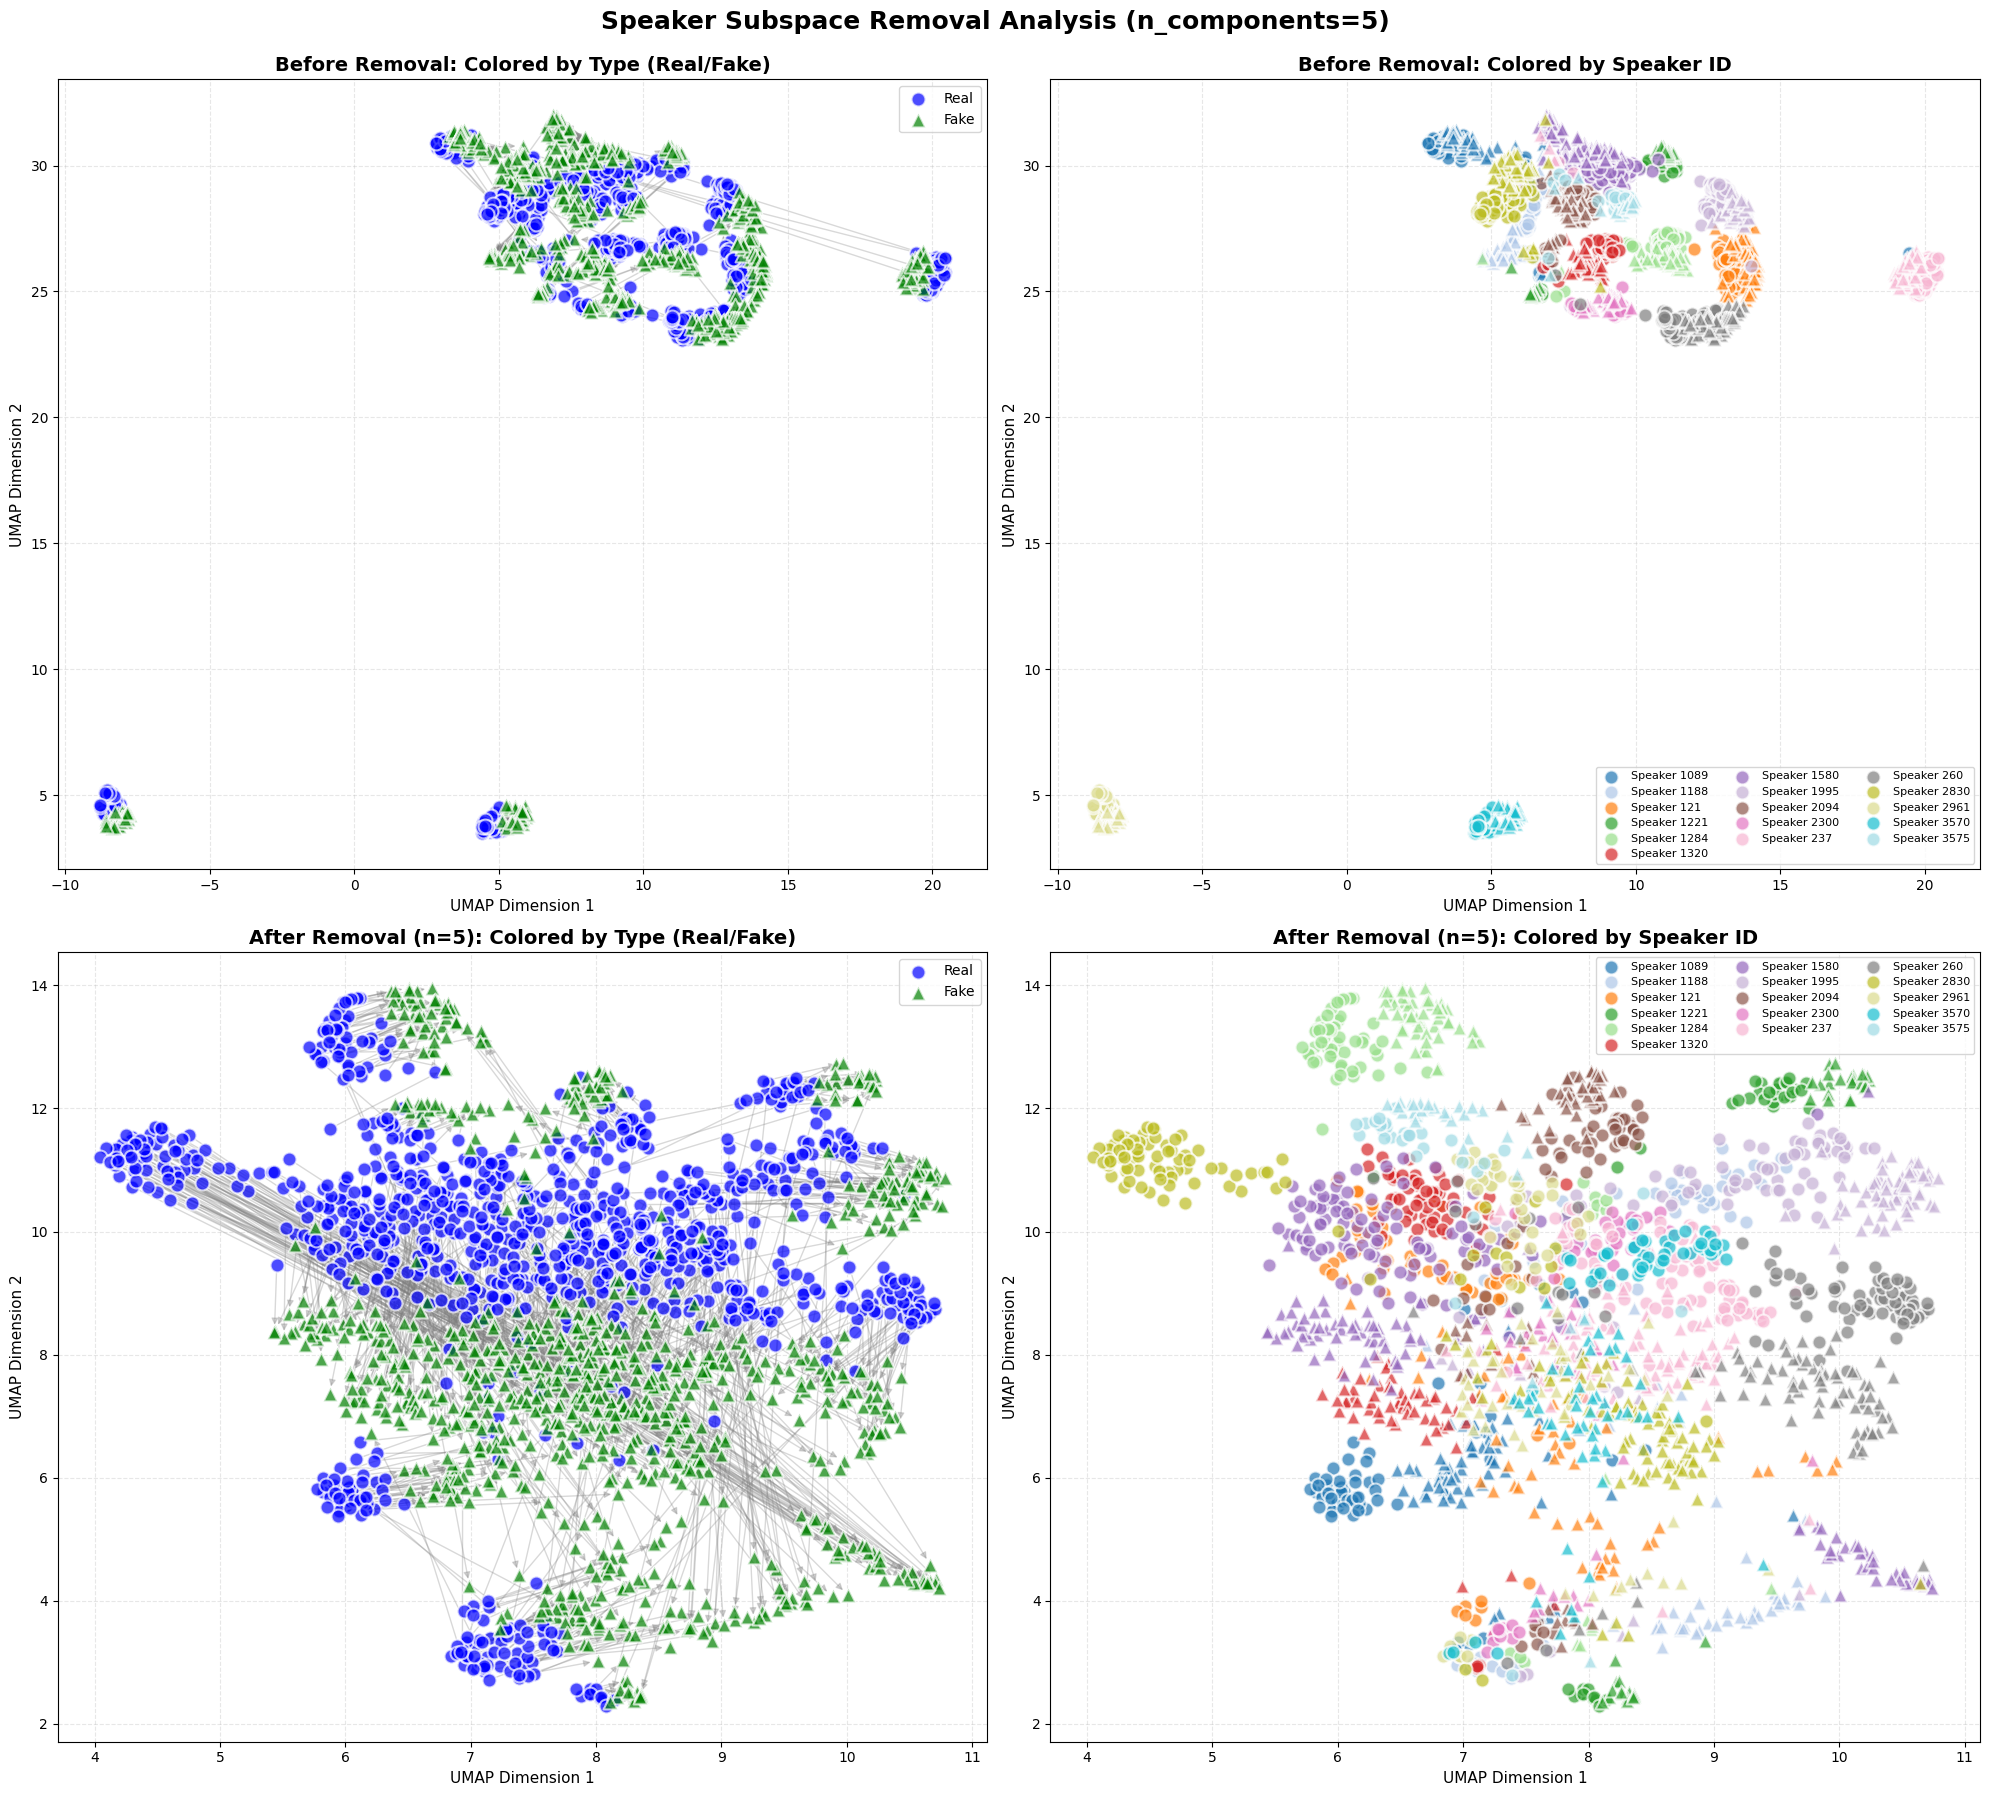

In [10]:
n_components = 5
print(f"\n{'='*60}")
print(f"Experiment: n_speaker_components = {n_components}")
print(f"{'='*60}\n")

projection_matrix, pca = compute_speaker_subspace(X_scaled, speaker_ids, n_components)
X_projected = remove_speaker_info(X_scaled, projection_matrix)

plot_umap_comparison(X_scaled, X_projected, y, speaker_ids, n_components, filenames)

### 실험 2: n_speaker_components = 10


Experiment: n_speaker_components = 10

Computing PCA on 16 speaker centroids...
Explained variance by top 10 components: 0.8824
Running UMAP on original features...


/mnt/fr20tb/kyudan/miniforge3/envs/deepfake/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP on projected features...


/mnt/fr20tb/kyudan/miniforge3/envs/deepfake/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_94629/3471156384.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_speakers))


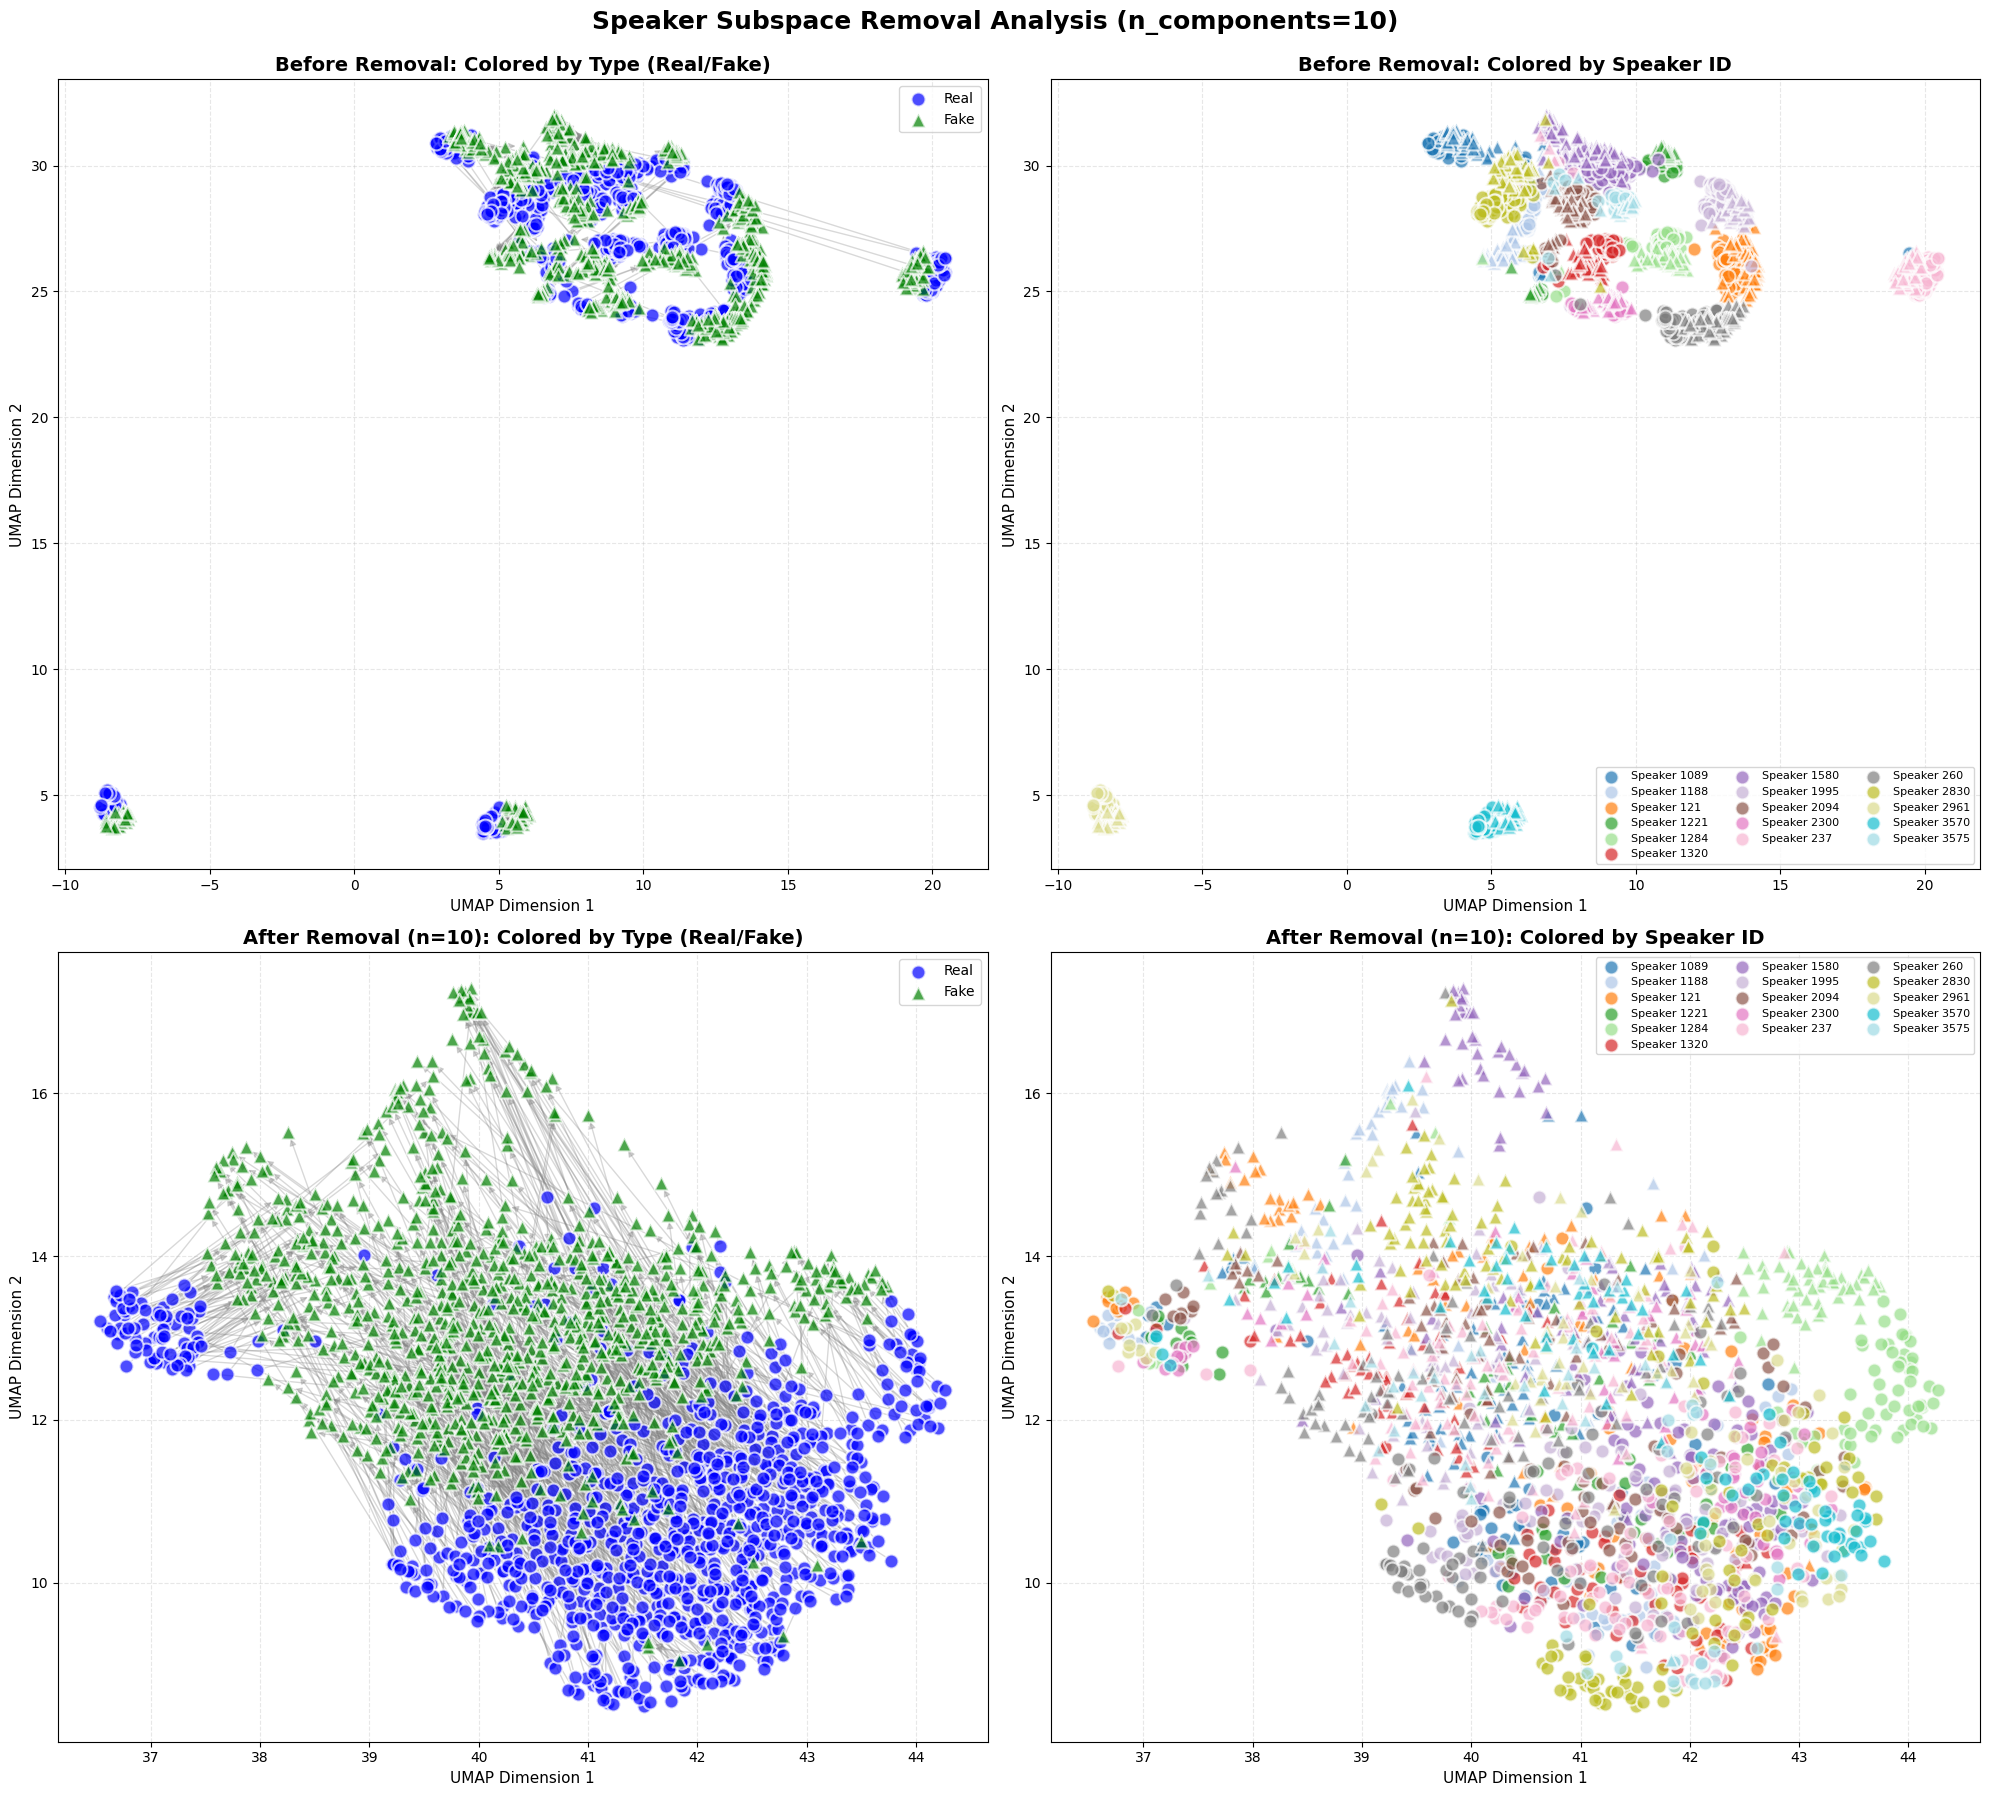

In [11]:
n_components = 10
print(f"\n{'='*60}")
print(f"Experiment: n_speaker_components = {n_components}")
print(f"{'='*60}\n")

projection_matrix, pca = compute_speaker_subspace(X_scaled, speaker_ids, n_components)
X_projected = remove_speaker_info(X_scaled, projection_matrix)

plot_umap_comparison(X_scaled, X_projected, y, speaker_ids, n_components, filenames)

### 실험 3: n_speaker_components = 20


Experiment: n_speaker_components = 16

Computing PCA on 16 speaker centroids...
Explained variance by top 16 components: 1.0000
Running UMAP on original features...


/mnt/fr20tb/kyudan/miniforge3/envs/deepfake/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP on projected features...


/mnt/fr20tb/kyudan/miniforge3/envs/deepfake/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_94629/3471156384.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_speakers))


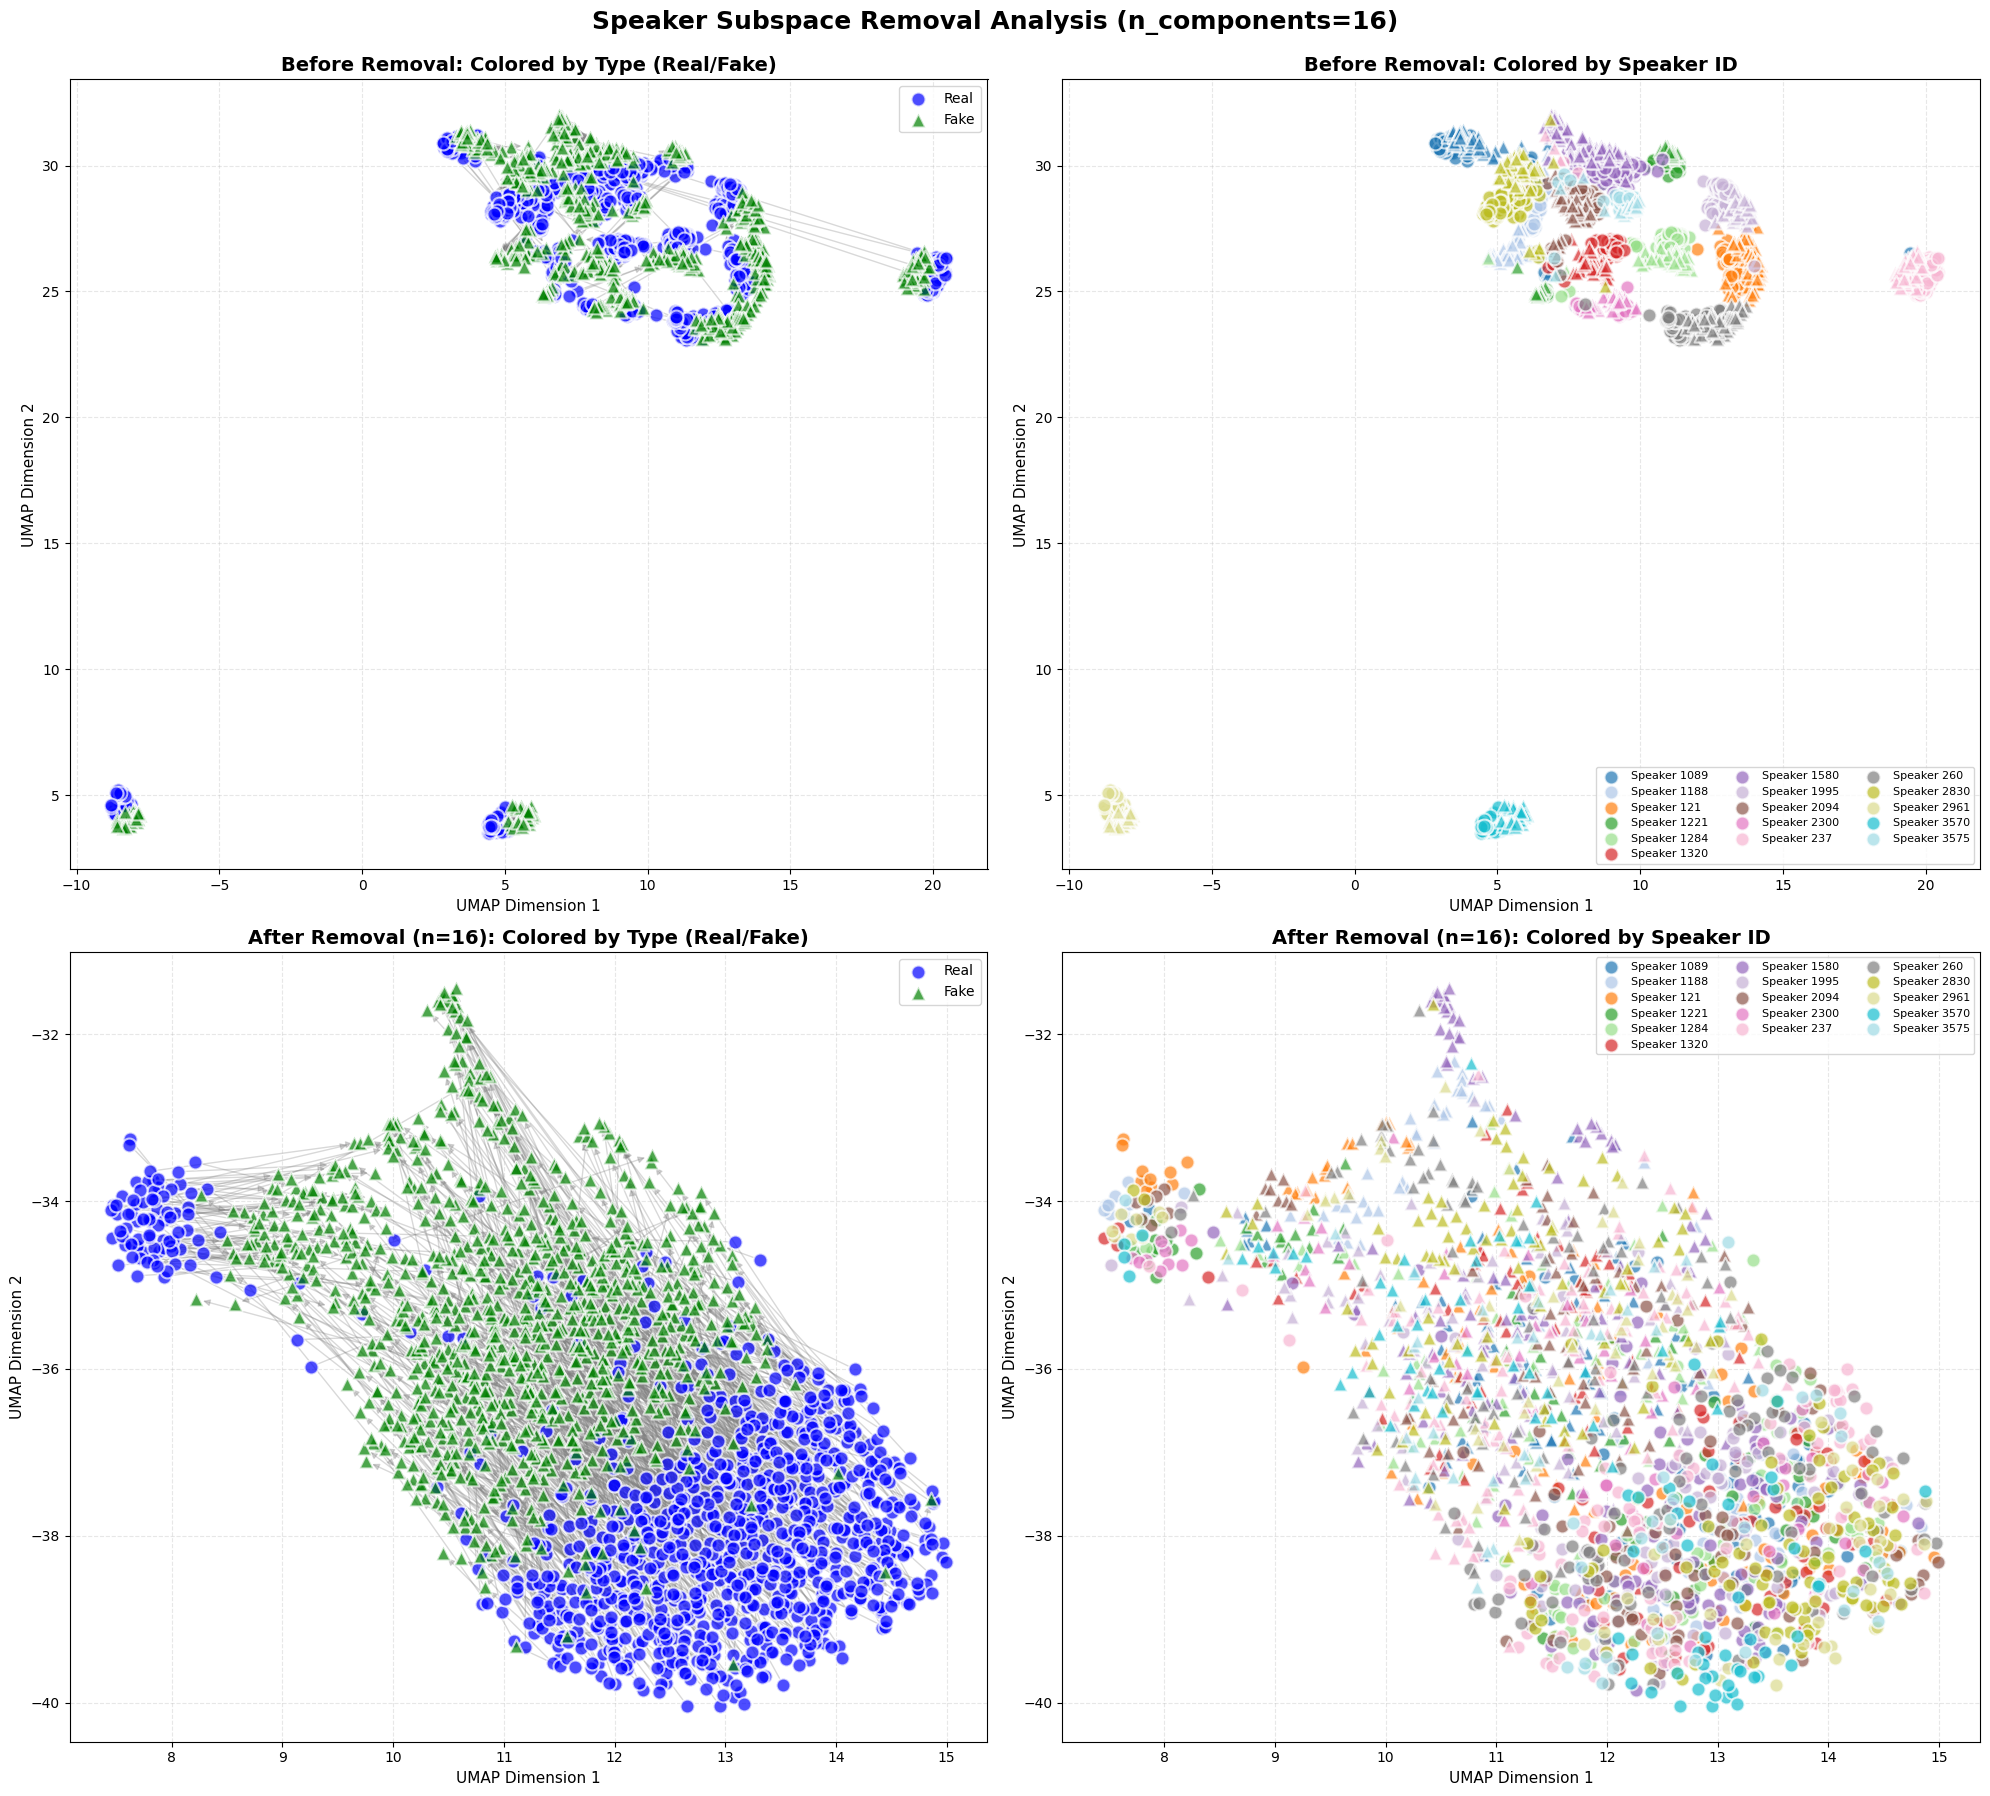

In [13]:
n_components = 16
print(f"\n{'='*60}")
print(f"Experiment: n_speaker_components = {n_components}")
print(f"{'='*60}\n")

projection_matrix, pca = compute_speaker_subspace(X_scaled, speaker_ids, n_components)
X_projected = remove_speaker_info(X_scaled, projection_matrix)

plot_umap_comparison(X_scaled, X_projected, y, speaker_ids, n_components, filenames)

## 6. Explained Variance 분석

각 n_components 값에서 제거되는 화자 정보의 분산 비율을 확인합니다.

Computing PCA on 16 speaker centroids...
Explained variance by top 1 components: 0.1713
n=  1: Explained variance = 0.1713
Computing PCA on 16 speaker centroids...
Explained variance by top 5 components: 0.6398
n=  5: Explained variance = 0.6398
Computing PCA on 16 speaker centroids...
Explained variance by top 10 components: 0.8824
n= 10: Explained variance = 0.8824
Computing PCA on 16 speaker centroids...
Explained variance by top 16 components: 1.0000
n= 16: Explained variance = 1.0000


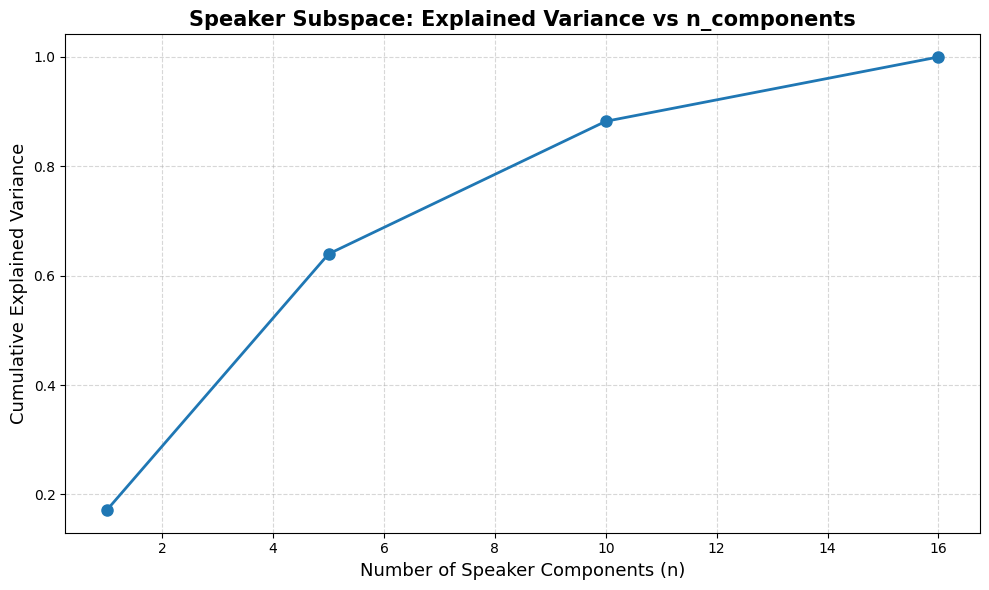

In [14]:
# 다양한 n_components 값에 대한 Explained Variance 계산
n_components_list = [1, 5, 10, 16]
explained_variances = []

for n in n_components_list:
    if n > len(np.unique(speaker_ids)):
        print(f"Skipping n={n} (exceeds number of speakers)")
        continue
    
    _, pca = compute_speaker_subspace(X_scaled, speaker_ids, n)
    total_var = sum(pca.explained_variance_ratio_)
    explained_variances.append(total_var)
    print(f"n={n:3d}: Explained variance = {total_var:.4f}")

# 시각화
valid_n = [n for n in n_components_list if n <= len(np.unique(speaker_ids))]
plt.figure(figsize=(10, 6))
plt.plot(valid_n[:len(explained_variances)], explained_variances, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Speaker Components (n)', fontsize=13)
plt.ylabel('Cumulative Explained Variance', fontsize=13)
plt.title('Speaker Subspace: Explained Variance vs n_components', fontsize=15, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 7. 결론 및 분석

### 관찰 포인트:
1. **Speaker ID별 색상 구분 (오른쪽 플롯)**
   - Before: 화자별로 cluster가 형성되어 있는가?
   - After: n이 증가하면서 화자 cluster가 약해지는가?

2. **Real/Fake 구분 (왼쪽 플롯)**
   - Before: Real(파랑)과 Fake(초록)이 섞여 있는가?
   - After: n이 증가하면서 Real/Fake가 더 명확하게 분리되는가?

3. **최적 n_components 선택**
   - 화자 정보는 충분히 제거되면서
   - Fake detection에 필요한 정보는 보존되는 지점
   - 보통 10~20 사이에서 좋은 결과를 기대할 수 있음

### 다음 단계:
- 선택된 n_components로 실제 분류기 학습
- Test set에서 성능 평가
- Cross-validation으로 일반화 성능 확인